In [1]:
import os
import json
import pandas as pd
import numpy as np

In [2]:
# Load JSON

output_xlsx_file_name = 'combined_results-llama_3.3_70b_tp4_random.xlsx'
json_files_dir = '../results/llama3.3_70b/bf16-tp_4-random'

json_dfs = []

for json_file in os.listdir(json_files_dir):
    if not json_file.endswith('.json'):
        continue
    
    with open(os.path.join(json_files_dir, json_file), 'r') as f:
        data = json.load(f)

    # Remove unwanted fields
    unwanted_fields = {"ttfts", "itls", "generated_texts", "errors"}
    data = {k: v for k, v in data.items() if k not in unwanted_fields}

    # Compute statistics for input_lens and output_lens
    for key in ["input_lens", "output_lens"]:
        if key in data:
            values = np.array(data[key])
            prefix = "input" if key == "input_lens" else "output"
            data[f"mean_{prefix}_lens"] = np.mean(values)
            data[f"median_{prefix}_lens"] = np.median(values)
            data[f"std_{prefix}_lens"] = np.std(values)
            data[f"p99_{prefix}_lens"] = np.percentile(values, 99)
            del data[key]  # Remove the original list
    
    # Add requested input and output tokens, and concurrency
    input_tokens = json_file.split('-')[-3]
    output_tokens = json_file.split('-')[-2]
    concurrency = json_file.split('-')[-1].split('.')[0]
    
    data["input_tokens"] = int(input_tokens)
    data["output_tokens"] = int(output_tokens)
    data["concurrency"] = int(concurrency)
    
    # Convert to DataFrame
    df_data = pd.DataFrame([data])
    
    json_dfs.append(df_data)

# Concatenate all DataFrames
df = pd.concat(json_dfs, ignore_index=True)
df.head()

,date,backend,model_id,tokenizer_id,num_prompts,request_rate,burstiness,max_concurrency,duration,completed,...,median_input_lens,std_input_lens,p99_input_lens,mean_output_lens,median_output_lens,std_output_lens,p99_output_lens,input_tokens,output_tokens,concurrency
0,20250602-213507,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,8,inf,1.0,None,31.011890,8,...,2047.0,0.0,2047.0,2048.0,2048.0,0.0,2048.0,2048,2048,8
1,20250602-213812,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,16,inf,1.0,None,30.673973,16,...,127.0,0.0,127.0,2048.0,2048.0,0.0,2048.0,128,2048,16
2,20250602-230705,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,256,inf,1.0,None,94.501299,256,...,1023.0,0.0,1023.0,2048.0,2048.0,0.0,2048.0,1024,2048,256
3,20250602-211517,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,1,inf,1.0,None,28.831974,1,...,2047.0,0.0,2047.0,2048.0,2048.0,0.0,2048.0,2048,2048,1
4,20250602-230757,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,256,inf,1.0,None,40.804342,256,...,2047.0,0.0,2047.0,128.0,128.0,0.0,128.0,2048,128,256


In [3]:
df.to_excel(os.path.join(json_files_dir,output_xlsx_file_name), index=False)

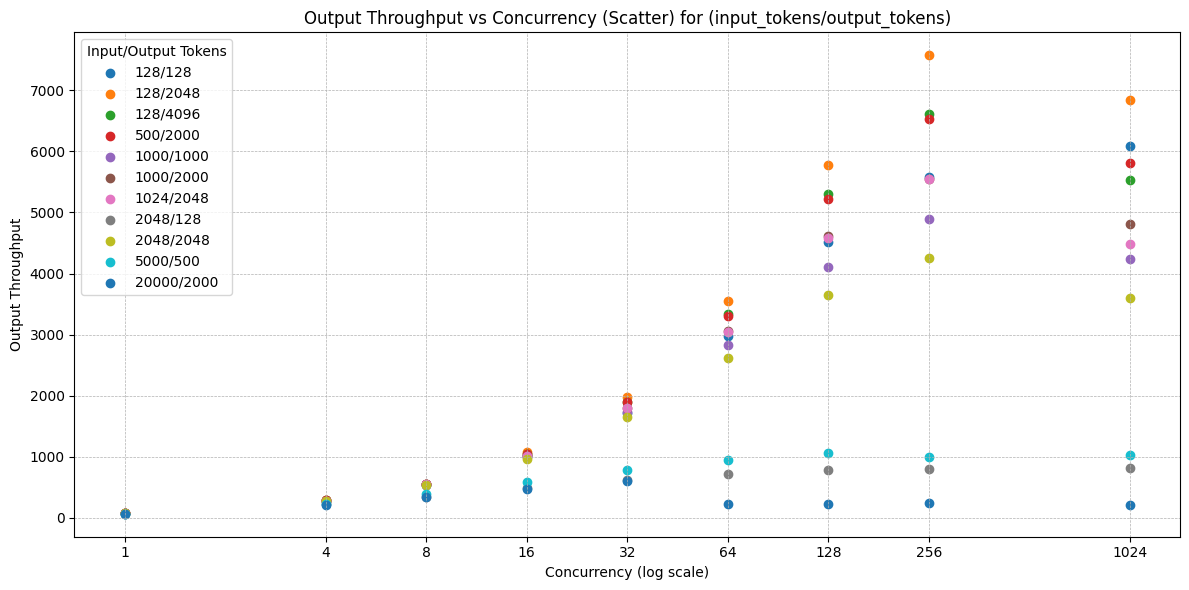

In [4]:
import matplotlib.pyplot as plt 

# Group by (input_tokens, output_tokens)
# Plotting
plt.figure(figsize=(12, 6))

if df['input_tokens'].unique()[0] == 0 and df['output_tokens'].unique()[0] == 0:
    plt.scatter(df['concurrency'], df['output_throughput'])
    plt.title('Output Throughput vs Concurrency (Scatter)')
else:
    grouped = df.groupby(['input_tokens', 'output_tokens'])
    for (input_tok, output_tok), group in grouped:
        plt.scatter(group['concurrency'], group['output_throughput'], label=f'{input_tok}/{output_tok}')
    plt.title('Output Throughput vs Concurrency (Scatter) for (input_tokens/output_tokens)')
    plt.legend(title='Input/Output Tokens')

# Set x-axis ticks and log scale
concurrency_ticks = sorted(df['concurrency'].unique())
plt.xscale('log', base=2)
plt.xticks(concurrency_ticks, labels=[str(c) for c in concurrency_ticks])
plt.xlabel('Concurrency (log scale)')
plt.ylabel('Output Throughput')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

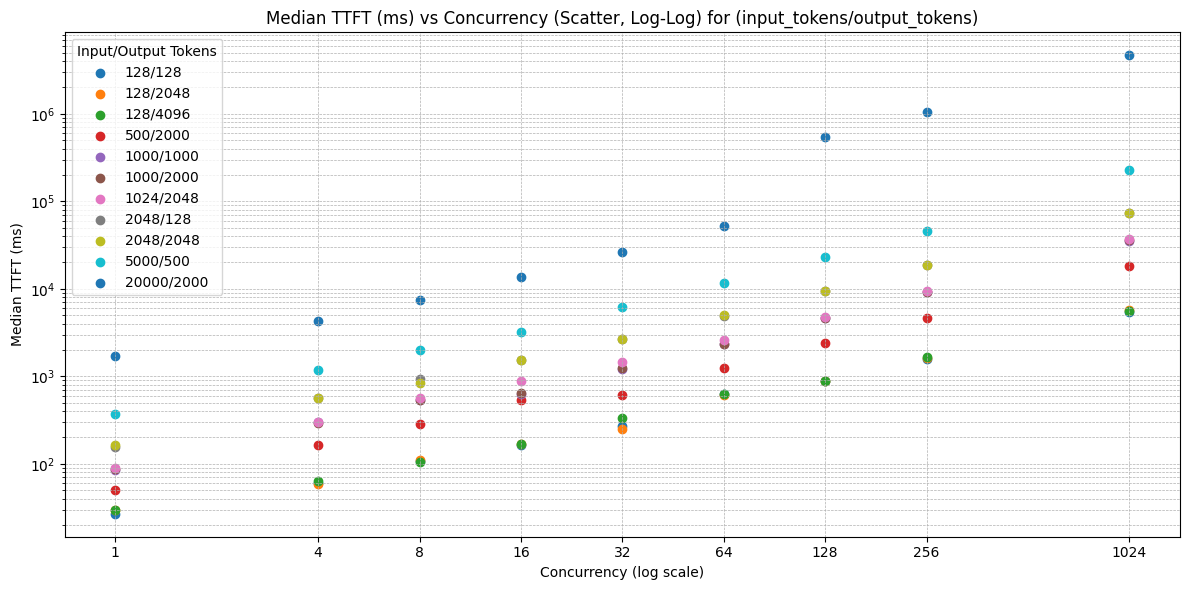

In [5]:
# Plotting
plt.figure(figsize=(12, 6))

if df['input_tokens'].unique()[0] == 0 and df['output_tokens'].unique()[0] == 0:
    plt.scatter(df['concurrency'], df['median_ttft_ms'])
    plt.title('Median TTFT (ms) vs Concurrency (Scatter)')
else:
    grouped = df.groupby(['input_tokens', 'output_tokens'])
    for (input_tok, output_tok), group in grouped:
        plt.scatter(group['concurrency'], group['median_ttft_ms'], label=f'{input_tok}/{output_tok}')
    plt.title('Median TTFT (ms) vs Concurrency (Scatter, Log-Log) for (input_tokens/output_tokens)')
    plt.legend(title='Input/Output Tokens')

# Set x-axis ticks and log scale
concurrency_ticks = sorted(df['concurrency'].unique())
plt.xscale('log', base=2)
plt.xticks(concurrency_ticks, labels=[str(c) for c in concurrency_ticks])

# Set y-axis log scale to compress outliers
plt.yscale('log')
plt.ylabel('Median TTFT (ms)')
plt.xlabel('Concurrency (log scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [6]:
# Load JSON

output_xlsx_file_name = 'combined_results-llama_3.3_70b_tp8_sharegpt.xlsx'
json_files_dir = '../results/llama3.3_70b/bf16-tp_8-sharegpt'

json_dfs = []

for json_file in os.listdir(json_files_dir):
    if not json_file.endswith('.json'):
        continue
    
    with open(os.path.join(json_files_dir, json_file), 'r') as f:
        data = json.load(f)

    # Remove unwanted fields
    unwanted_fields = {"ttfts", "itls", "generated_texts", "errors"}
    data = {k: v for k, v in data.items() if k not in unwanted_fields}

    # Compute statistics for input_lens and output_lens
    for key in ["input_lens", "output_lens"]:
        if key in data:
            values = np.array(data[key])
            prefix = "input" if key == "input_lens" else "output"
            data[f"mean_{prefix}_lens"] = np.mean(values)
            data[f"median_{prefix}_lens"] = np.median(values)
            data[f"std_{prefix}_lens"] = np.std(values)
            data[f"p99_{prefix}_lens"] = np.percentile(values, 99)
            del data[key]  # Remove the original list
    
    # Add requested input and output tokens, and concurrency
    input_tokens = json_file.split('-')[-3]
    output_tokens = json_file.split('-')[-2]
    concurrency = json_file.split('-')[-1].split('.')[0]
    
    data["input_tokens"] = int(input_tokens)
    data["output_tokens"] = int(output_tokens)
    data["concurrency"] = int(concurrency)
    
    # Convert to DataFrame
    df_data = pd.DataFrame([data])
    
    json_dfs.append(df_data)

# Concatenate all DataFrames
df_tp8 = pd.concat(json_dfs, ignore_index=True)
df_tp8.head()

,date,backend,model_id,tokenizer_id,num_prompts,request_rate,burstiness,max_concurrency,duration,completed,...,median_input_lens,std_input_lens,p99_input_lens,mean_output_lens,median_output_lens,std_output_lens,p99_output_lens,input_tokens,output_tokens,concurrency
0,20250530-181440,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,64,inf,1.0,None,9.530629,64,...,78.5,256.521137,781.84,200.234375,140.5,201.148557,768.74,0,0,64
1,20250530-181324,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,4,inf,1.0,None,7.809727,4,...,19.0,7.361216,26.94,329.250000,213.5,257.683309,753.89,0,0,4
2,20250530-181419,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,32,inf,1.0,None,8.724196,32,...,52.0,236.951602,761.94,206.156250,140.5,205.243013,761.01,0,0,32
3,20250530-181500,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,128,inf,1.0,None,11.035287,128,...,109.5,243.603153,793.36,215.687500,156.5,207.370545,768.00,0,0,128
4,20250530-181610,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,1024,inf,1.0,None,35.077047,984,...,85.0,242.269446,781.31,191.548828,133.0,197.227441,768.00,0,0,1024


In [40]:
# Load JSON

output_xlsx_file_name = 'combined_results-llama_3.3_70b_tp4_sharegpt.xlsx'
json_files_dir = '../results/llama3.3_70b/bf16-tp_4-sharegpt'

json_dfs = []

for json_file in os.listdir(json_files_dir):
    if not json_file.endswith('.json'):
        continue
    
    with open(os.path.join(json_files_dir, json_file), 'r') as f:
        data = json.load(f)

    # Remove unwanted fields
    unwanted_fields = {"ttfts", "itls", "generated_texts", "errors"}
    data = {k: v for k, v in data.items() if k not in unwanted_fields}

    # Compute statistics for input_lens and output_lens
    for key in ["input_lens", "output_lens"]:
        if key in data:
            values = np.array(data[key])
            prefix = "input" if key == "input_lens" else "output"
            data[f"mean_{prefix}_lens"] = np.mean(values)
            data[f"median_{prefix}_lens"] = np.median(values)
            data[f"std_{prefix}_lens"] = np.std(values)
            data[f"p99_{prefix}_lens"] = np.percentile(values, 99)
            del data[key]  # Remove the original list
    
    # Add requested input and output tokens, and concurrency
    input_tokens = json_file.split('-')[-3]
    output_tokens = json_file.split('-')[-2]
    concurrency = json_file.split('-')[-1].split('.')[0]
    
    data["input_tokens"] = int(input_tokens)
    data["output_tokens"] = int(output_tokens)
    data["concurrency"] = int(concurrency)
    
    # Convert to DataFrame
    df_data = pd.DataFrame([data])
    
    json_dfs.append(df_data)

# Concatenate all DataFrames
df_tp4 = pd.concat(json_dfs, ignore_index=True)
df_tp4.head()

,date,backend,model_id,tokenizer_id,num_prompts,request_rate,burstiness,max_concurrency,duration,completed,...,median_input_lens,std_input_lens,p99_input_lens,mean_output_lens,median_output_lens,std_output_lens,p99_output_lens,input_tokens,output_tokens,concurrency
0,20250530-183906,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,64,inf,1.0,None,12.708730,64,...,78.5,256.521137,781.84,200.234375,140.5,201.148557,768.74,0,0,64
1,20250530-183735,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,4,inf,1.0,None,10.673050,4,...,19.0,7.361216,26.94,329.250000,213.5,257.683309,753.89,0,0,4
2,20250530-183842,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,32,inf,1.0,None,11.492373,32,...,52.0,236.951602,761.94,206.156250,140.5,205.243013,761.01,0,0,32
3,20250530-183931,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,128,inf,1.0,None,14.389125,128,...,109.5,243.603153,793.36,215.687500,156.5,207.370545,768.00,0,0,128
4,20250530-184058,vllm,meta-llama/Llama-3.3-70B-Instruct,meta-llama/Llama-3.3-70B-Instruct,1024,inf,1.0,None,45.819306,984,...,85.0,242.269446,781.31,191.833984,133.0,197.473035,768.00,0,0,1024


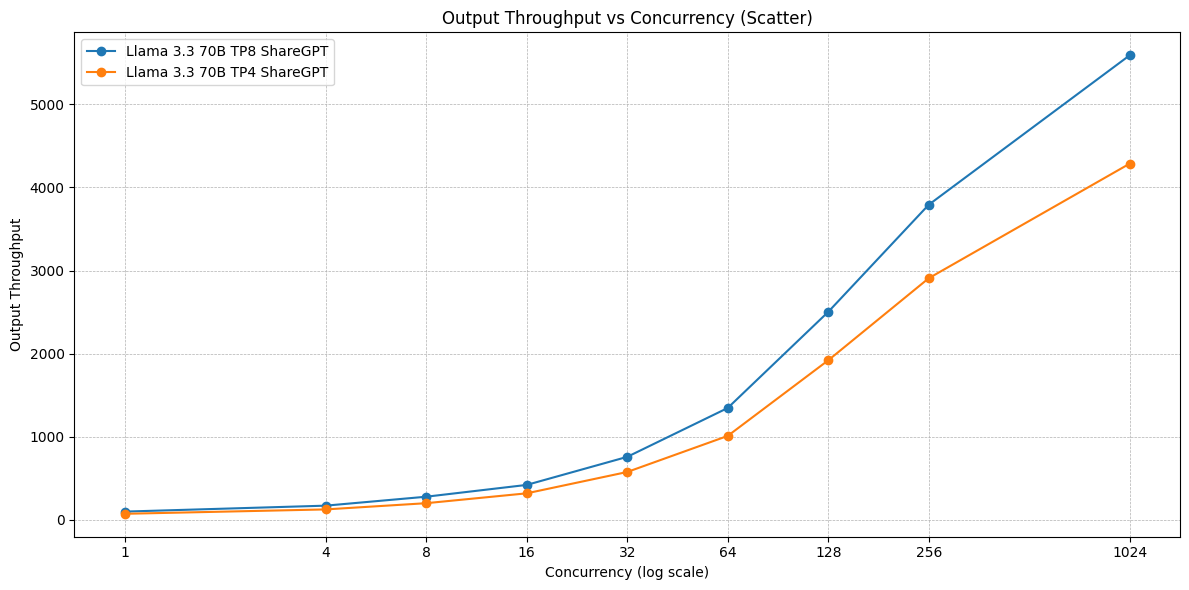

In [48]:
import matplotlib.pyplot as plt 

# Group by (input_tokens, output_tokens)
# Plotting
plt.figure(figsize=(12, 6))

df_tp8.sort_values(by='concurrency', inplace=True)
df_tp4.sort_values(by='concurrency', inplace=True)

plt.plot(df_tp8['concurrency'], df_tp8['output_throughput'], marker='o', label='Llama 3.3 70B TP8 ShareGPT')
plt.plot(df_tp4['concurrency'], df_tp4['output_throughput'], marker='o', label='Llama 3.3 70B TP4 ShareGPT')
plt.title('Output Throughput vs Concurrency (Scatter)')

# Set x-axis ticks and log scale
concurrency_ticks = sorted(df['concurrency'].unique())
plt.xscale('log', base=2)
plt.xticks(concurrency_ticks, labels=[str(c) for c in concurrency_ticks])
plt.xlabel('Concurrency (log scale)')
plt.ylabel('Output Throughput')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend
plt.legend()
plt.tight_layout()

plt.show()